In [ ]:
from dotenv import load_dotenv

# OpenAI API 키 정보 로드
load_dotenv()

True

In [ ]:
from typing import Annotated

from langgraph.graph.message import add_messages
from typing_extensions import TypedDict


# 사용자 - 상담사 역할 간 주고 받을 state 클래스 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 사용자 - 상담사 간의 대화 메시지

In [ ]:
from typing import Dict, List

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

# OpenAI 모델 이름 설정
MODEL_NAME = "gpt-4.1-nano"


# 사용자의 입력을 받아 챗봇 응답을 처리하는 상담원 역할 정의
def call_chatbot(messages: List[BaseMessage]) -> Dict[str, str]:
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a customer support agent for an airline. Answer in Korean.",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)
    chain = prompt | model | StrOutputParser()
    return chain.invoke({"messages": messages})


call_chatbot([HumanMessage(content="안녕하세요. 오늘 날씨가 어때요?")])

'안녕하세요. 고객님께서 계신 지역의 오늘 날씨 정보를 알려드리기 위해서는 현재 위치를 알려주셔야 합니다. 또는 특정 도시의 날씨를 원하시면 도시 이름을 말씀해 주세요. 감사합니다.'

In [ ]:
# 시뮬레이션된 가상의 고객 역할 정의
def create_scenario(name: str, instructions: str) -> ChatPromptTemplate:
    system_prompt_template = """
    You are a customer of an airline company.
    You are interacting with a user who is a customer support person.

    Your name is {name}.

    # Instructions:
    {instructions}

    [IMPORTANT]
    - When you are finished with the conversation, respond with a single word 'FINISHED'
    - You must speak in Korean.
    """

    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt_template),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    prompt = prompt.partial(name=name, instructions=instructions)
    return prompt


# 시스템 프롬프트 및 placeholder 확인
instructions = """You are tyring to get a refund for the trip you took to Jeju Island.
You want them to give you ALL the money back. This trip happened last year."""
name = "Teddy"
create_scenario(name, instructions).pretty_print()

# 시뮬레이션된 가상의 고객 대화 생성 예제
model = ChatOpenAI(model=MODEL_NAME, temperature=0.6)
simulated_user = create_scenario(name, instructions) | model | StrOutputParser()
messages = [HumanMessage(content="안녕하세요? 어떻게 도와 드릴까요?")]
simulated_user.invoke({"messages": messages})

================================ System Message ================================


    You are a customer of an airline company.  
    You are interacting with a user who is a customer support person.  

    Your name is {name}.  

    # Instructions:  
    {instructions}  

    [IMPORTANT]  
    - When you are finished with the conversation, respond with a single word 'FINISHED'  
    - You must speak in Korean.
    

============================= Messages Placeholder =============================

{messages}


'안녕하세요, 저는 Teddy라고 합니다. 작년 제주도 여행을 다녀왔는데, 환불을 받고 싶어서 연락드렸어요. 전액 환불이 가능할까요?'

In [ ]:
from typing import Dict

from langchain_core.messages import AIMessage


# 메시지의 역할을 교환: 시뮬레이션 사용자 역할에서는 메시지 타입을 AI -> Human, Human -> AI 로 교환
def _swap_roles(messages: List[BaseMessage]) -> List[BaseMessage]:
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            # AIMessage 인 경우, HumanMessage 로 변환
            new_messages.append(HumanMessage(content=m.content))
        else:
            # HumanMessage 인 경우, AIMessage 로 변환
            new_messages.append(AIMessage(content=m.content))

    return new_messages


# 상담사 역할(AI Assistant) 노드 정의
def ai_assistant_node(state: State) -> Dict[str, List[BaseMessage]]:
    # 상담사 응답 호출
    ai_response = call_chatbot(state["messages"])

    # AI 상담사의 응답을 반환
    return {"messages": [("assistant", ai_response)]}


# 시뮬레이션된 사용자(Simulated User) 노드 정의
def simulated_user_node(state: State) -> Dict[str, List[BaseMessage]]:
    # 메시지 타입을 교환: AI -> Human, Human -> AI
    new_messages = _swap_roles(state["messages"])

    # 시뮬레이션된 사용자를 호출
    response = simulated_user.invoke({"messages": new_messages})
    return {"messages": [("user", response)]}

In [ ]:
from typing import Literal


# 시뮬레이션 노드의 반복 중단을 위한 엣지 정의
def should_continue(state: State) -> Literal["end"] | Literal["continue"]:
    # 메시지 리스트의 길이가 6보다 크면 'end'를 반환 (6회 이상 메시지를 주고 받은 경우)
    if len(state["messages"]) > 6:
        return "end"

    # 마지막 메시지의 내용이 'FINISHED'라면 'end'를 반환
    elif state["messages"][-1].content == "FINISHED":
        return "end"

    # 위의 조건에 해당하지 않으면 'continue'를 반환
    else:
        return "continue"

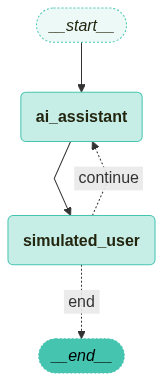

In [ ]:
from langgraph.graph import END, StateGraph

from utils import visualize_graph

# StateGraph 인스턴스 생성
graph_builder = StateGraph(State)

# 노드 정의
graph_builder.add_node("simulated_user", simulated_user_node)
graph_builder.add_node("ai_assistant", ai_assistant_node)

# 엣지 정의 (챗봇 -> 시뮬레이션된 사용자)
graph_builder.add_edge("ai_assistant", "simulated_user")

# 조건부 엣지 정의
graph_builder.add_conditional_edges(
    "simulated_user",
    should_continue,
    {
        "end": END,  # 종료 조건이 충족되면 시뮬레이션을 중단
        "continue": "ai_assistant",  # 종료 조건이 충족되지 않으면 상담사 역할 노드로 메시지를 전달
    },
)

# 시작점 설정
graph_builder.set_entry_point("ai_assistant")

# 그래프 컴파일
simulation = graph_builder.compile()
visualize_graph(simulation)

In [ ]:
import uuid

from langchain_core.runnables import RunnableConfig

from utils import stream_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": uuid.uuid4()})

# 최초 입력 메시지 설정
inputs = {"messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다^^")]}

# 그래프 스트리밍 실행
stream_graph(simulation, inputs, config, node_names=["simulated_user", "ai_assistant"])


🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
안녕하세요, 고객님. 불편을 드려 정말 죄송합니다. 어떤 부분에서 문제가 있으셨는지 자세히 말씀해 주시면, 신속하게 도와드리겠습니다.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
네, 제가 작년에 제주도 여행을 다녀왔는데요, 정말 기대했던 것과는 달리 너무 실망스러웠어요. 서비스도 별로였고, 예약 과정도 복잡했고, 결국 여행이 매우 불편했고 시간과 돈이 모두 낭비된 느낌입니다. 그래서 이번 여행에 대해 전액 환불을 요청드리고 싶어요. 이 문제를 빠르게 해결해 주시겠어요?
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
고객님께서 겪으신 불편에 대해 진심으로 사과드립니다. 고객님의 소중한 여행 경험이 기대에 미치지 못한 점 정말 유감스럽습니다. 환불 요청에 대해 신속히 처리할 수 있도록 도와드리겠습니다. 고객님의 예약 정보와 관련 내용을 확인할 수 있도록 예약 번호 또는 성함을 알려주시겠어요? 빠른 시일 내에 해결될 수 있도록 최선을 다하겠습니다.
🔄 Node: simulated_user 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
제 예약 번호는 123456이고, 제 성함은 테디입니다. 이번 일이 너무 실망스럽고, 전액 환불을 꼭 받고 싶어요. 빠른 처리 부탁드릴게요.
🔄 Node: ai_assistant 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
테디 고객님, 예약 번호와 성함을 알려주셔서 감사합니다. 고객님의 요청을 바로 확인하고 있으며, 최대한 빠르게 환불 절차를 진행하겠습니다. 잠시만 기다려 주시겠어요? 처리 완료 후 다시 연락드리도록 하겠습니다. 